In [1]:
import os
import json
import pandas as pd
from tqdm import tqdm

In [2]:
def read_json_file(_path):
    with open(_path) as json_file:
        return json.load(json_file)

In [3]:
def get_categories(_category_path, _categories):

    _categories_df = pd.read_csv(_category_path, header=None)

    _categories_dict = {}
    for i, row in _categories_df.iterrows():
        if row[1] in _categories:
            _categories_dict[row[0]] = row[1]

    return _categories_dict

In [7]:
def get_data(_data_path, _category_path, _categories):

    _orig_data = read_json_file(_data_path)

    _categories_dict = get_categories(_category_path, _categories)

    _final_data = []
    for _set_data in tqdm(_orig_data):
        _tmp_items = []
        for _item_data in _set_data["items"]:
            if _item_data["categoryid"] in _categories_dict:
                _item_data["categoryname"] = _categories_dict[_item_data["categoryid"]]
                _item_data["set_id"] = _set_data["set_id"]
                _item_data["id"] = f"{_set_data['set_id']}_{_item_data['index']}"
                _item_data["path"] = f"./../datasets/Polyvore/maryland-polyvore-images-1/maryland-polyvore-images/versions/1/images/{_set_data['set_id']}/{_item_data['index']}.jpg"
                _tmp_items.append(_item_data)

        if len(_tmp_items) > 1:
            _set_data["items"] = _tmp_items
            _final_data.append(_set_data)

    return _final_data

# Polyvore

In [8]:
train_set_data = get_data(
    "./../datasets/Polyvore/polyvore/train_no_dup.json",
    "./../datasets/Polyvore/polyvore/categories.csv",
    ["pants", "shirt"]
)

100%|██████████| 17316/17316 [00:00<00:00, 543005.15it/s]


In [9]:
train_item_data = []
for set_data in train_set_data:
    train_item_data += set_data["items"]

In [10]:
len(train_item_data)

1321

In [11]:
pants = []
shirts = []
for d in train_item_data:
    if d["categoryname"] == "pants":
        pants.append(d)
    else:
        shirts.append(d)

pants = pants[:50]
shirts = shirts[:50]

In [12]:
len(pants), len(shirts)

(50, 50)

In [13]:
SUGGESTION_SYSTEM_PROMPT = """
SYSTEM: You are a helpful fashion assistant whose job is to score how compatible a garment (e.g. a shirt) is with a list of other garments (e.g. a list of pants).
INSTRUCTIONS:
- Evaluate compatibility for styling (color, pattern, silhouette, formality, occasion), and practicality (season, material) using only the descriptions provided.
- Return a JSON array "results" sorted by descending "score".
- Score each candidate from 0 to 100 (100 = perfect match).
- Explain the score in "explanation".
- Keep "explanation" to 15-30 words.
- If information is missing, make reasonable assumptions and note them briefly.

INPUT:
Garment Type: pants
Garment Description: "Pants description text provided by user"

Candidates:
[
  { "id": "shirt_1", "description": "..." },
  { "id": "shirt_2", "description": "..." },
  ...
]

RESPONSE FORMAT (exact JSON):
{
  "results": [
    { "id": "shirt_5", "score": 92, "explanation": "Short reason" },
    { "id": "shirt_2", "score": 88, "explanation": "Short reason" },
    ...
  ]
}
"""

SUGGESTION_USER_PROMPT = """
Garment Type: {garment_type}
Garment Description: "{garment_description}"

Candidates:
{candidates}
"""


In [14]:
from together import Together
TOGETHER_AI_API_KEY="e83eac84fd3e06a1237468ccd1fac5b13a3e03c07f687a136645bfca19406cc2"
TOGETHER_AI_MODEL_NAME="meta-llama/Llama-3.3-70B-Instruct-Turbo-Free"

def togetherai_retrieve_response(system_prompt: str, user_prompt: str, **kwargs):

    client = Together(api_key=TOGETHER_AI_API_KEY)

    response = client.chat.completions.create(
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ],
        model=TOGETHER_AI_MODEL_NAME,
    )

    response = response.choices[0].message.content

    response = response.replace("```json", "").replace("```", "")
    return json.loads(response)


In [15]:
import random

In [16]:
d = random.choice(pants)
garment_type = d["categoryname"]
garment_description = d["name"]
candidates = [{f"id": c["id"], "description": c["name"]} for i, c in enumerate(shirts)]

In [17]:
resp = togetherai_retrieve_response(SUGGESTION_SYSTEM_PROMPT, SUGGESTION_USER_PROMPT.format(
    garment_type=garment_type,
    garment_description=garment_description,
    candidates=candidates,
))
resp

{'results': [{'id': '216536302_1',
   'score': 92,
   'explanation': 'Matching satin material'},
  {'id': '214546623_1', 'score': 90, 'explanation': 'Similar satin top'},
  {'id': '214546623_2', 'score': 90, 'explanation': 'Similar satin top'},
  {'id': '202255709_1', 'score': 80, 'explanation': 'Crochet and halter neck'},
  {'id': '212824273_1', 'score': 78, 'explanation': 'Strappy and crop top'},
  {'id': '207602996_1', 'score': 75, 'explanation': 'Striped and cotton top'},
  {'id': '205736516_1', 'score': 73, 'explanation': 'Sleeveless and crop top'},
  {'id': '201969694_1',
   'score': 70,
   'explanation': 'Oversized and long sleeve'},
  {'id': '183266525_1', 'score': 68, 'explanation': 'Cotton-blend and poplin'},
  {'id': '173061735_1', 'score': 65, 'explanation': 'Long sleeve and flannel'},
  {'id': '202334122_1', 'score': 63, 'explanation': 'Cotton and casual'},
  {'id': '202334122_2', 'score': 63, 'explanation': 'Cotton and casual'},
  {'id': '115731369_1', 'score': 60, 'expla

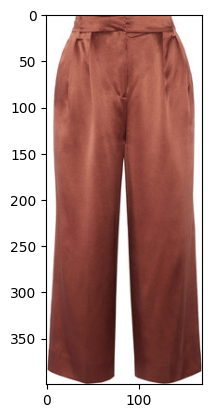

In [20]:
import matplotlib.pyplot as plt
from PIL import Image

img = Image.open(d["path"]).convert("RGB")
plt.imshow(img)
plt.show()

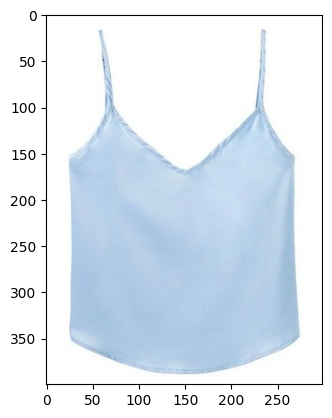

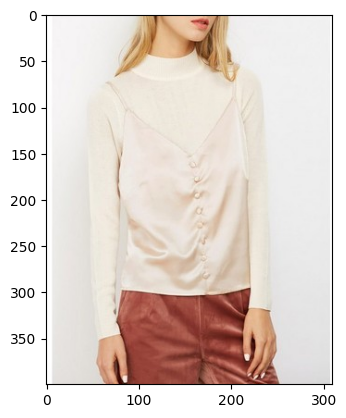

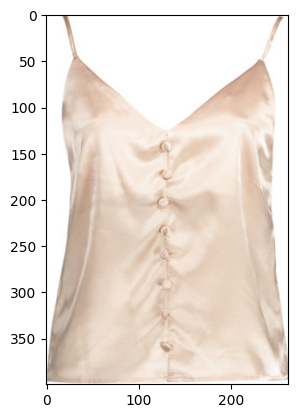

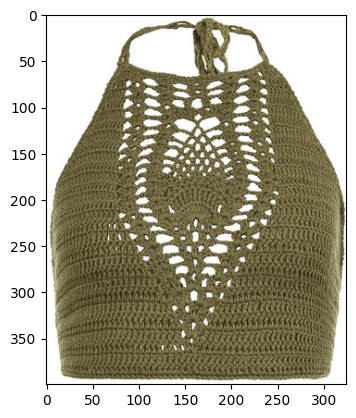

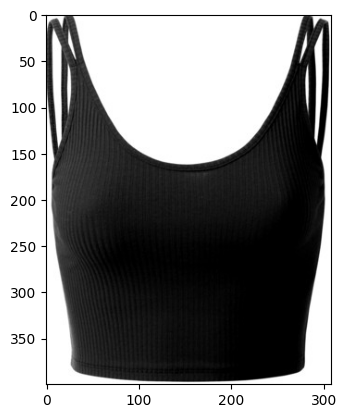

In [21]:
result = sorted(resp["results"], key=lambda x: x["score"], reverse=True)
for i in range(5):
    z = list(filter(lambda x: x["id"] == result[i]["id"], shirts))[0]
    img = Image.open(z["path"]).convert("RGB")
    plt.imshow(img)
    plt.show()